In [18]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from lightgbm.sklearn import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# import other functions
from imputer import *
from feature_eng import *
from drop import *

## Summary

|Model| Test MAE| Test MSE|
|-----|---------|---------|
| Simple LR | 99.675 | 190.922| 
| Ridge regression| 99.631 |190.895|
| Simple LGBM | 53.161 | 110.994 |
| LGBM with gridsearch | 
| LGBM with log transformed y | 51.2 | NA |


**Comments -** 


In [2]:
df = pd.read_csv("../data/train_data.zip")

In [3]:
df.head()

,external_id,month,year,monthly_number_of_sessions,monthly_unique_sessions,monthly_repeated_sessions,monthly_avg_length_of_session,monthly_avg_light_activity,monthly_avg_moderate_activity,monthly_avg_vigorous_activity,...,avg_wind_9_10,avg_wind_10_11,avg_wind_11_12,avg_wind_12_above,perfect_days,unacast_session_count,hpi,state_and_local_amount_per_capita,state_amount_per_capita,local_amount_per_capita
0,1804425,8,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,90.0,244.20,0.157475,0.009783,0.147692
1,1812706,2,2019,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,27.0,258.95,0.157475,0.009783,0.147692
2,1812706,3,2019,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,27.0,258.95,0.157475,0.009783,0.147692
3,1812706,11,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,24.0,258.95,0.157475,0.009783,0.147692
4,1812706,9,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,258.95,0.157475,0.009783,0.147692


## Pre-processing data

In [5]:
# drop rows missing target variable
df = drop_missing_unacast(df)

# create X and y
X = df.drop(columns = ['unacast_session_count'], axis=1)
y = df.loc[:, 'unacast_session_count']
# split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=0.2,
                                                      random_state=2020)
# impute NaN values
result = impute_data(X_train, X_valid)
X_train = result[0]
X_valid = result[1] 
# perform feature eng
X_train = comb_cols(X_train)
X_valid = comb_cols(X_valid)
# perform dropping
X_train = drop_columns(X_train)
X_valid = drop_columns(X_valid)

# perform OHE (climate, density_class, income_class)
X_train_valid = clean_categorical(X_train, X_valid)
X_train = X_train_valid[0]
X_valid = X_train_valid[1]

In [6]:
def show_scores(model, X, y, error = 'mse'):
    """
    Shows the mean squared error and mean absolute error for a given model
    and predictors and response
    
    Parameters
    ----------
    model: The sklearn model object
    X: numpy.ndarray        
        The predictors(independent variables) part of the data
    y: numpy.ndarray
        The response(target variable)of the data
    error: string,
        'mse' or 'mae' depending upon the type of error
        we are interested in
        
    Returns
    ------- 
    """            
    y_preds = model.predict(X)
    
    if error == 'mse':
        rmse = mean_squared_error(y, y_preds, squared = False)
        print("Root mean squared error: %0.3f" % rmse)
        return
    if error == 'mae':
        mae = mean_absolute_error(y, y_preds)
        print("Mean absolute error: %0.3f" % mae)
        return
    else:
        print("Wrong choice")

## Modelling with Linear regression

In [7]:
print(X_train.shape)
print(X_valid.shape)

(39592, 631)
(9898, 631)


### 1. Linear Regression

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Simple linear regression scores: ')
print('Train error: ')
show_scores(lr, X_train, y_train, 'mse')

print('Test error: ')    
show_scores(lr, X_valid, y_valid, 'mse')

Simple linear regression scores: 
Train error: 
Root mean squared error: 182.973
Test error: 
Root mean squared error: 190.922


In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Simple linear regression scores: ')
print('Train error: ')
show_scores(lr, X_train, y_train, 'mae')

print('Test error: ')    
show_scores(lr, X_valid, y_valid, 'mae')

Simple linear regression scores: 
Train error: 
Mean absolute error: 96.979
Test error: 
Mean absolute error: 99.675


### Observations 
- Better than last run. Proabably due to improved target.


### 4. Ridge L2

In [18]:
ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train, y_train)

print('Test error: ')    
show_scores(ridge_lr, X_valid, y_valid)

C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07072e-20): result may not be accurate.
  overwrite_a=True).T


Ridge regression scores: 
Train error: 
Root mean squared error: 182.989
Test error: 
Root mean squared error: 190.895


In [22]:
ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train, y_train, 'mae')

print('Test error: ')    
show_scores(ridge_lr, X_valid, y_valid, 'mae')

C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07072e-20): result may not be accurate.
  overwrite_a=True).T


Ridge regression scores: 
Train error: 
Mean absolute error: 96.934
Test error: 
Mean absolute error: 99.631


### Observations
- Same as LR


## LGBM on this data with Mean objective function

In [19]:
lgbm = LGBMRegressor(random_state = 2020)

lgbm.fit(X_train, y_train)

print('LGBM scores: ')

print('Train error: ')
show_scores(lgbm, X_train, y_train)

print('Test error: ')
show_scores(lgbm, X_valid, y_valid)

LGBM scores: 
Train error: 
Root mean squared error: 89.408
Test error: 
Root mean squared error: 110.994


**performing grid search**

In [19]:
params = {'max_depth' : [100, 300, 500], 'n_estimators' : [200, 400] }

lgbm = LGBMRegressor(random_state = 2020)

mse_scorer = make_scorer(mean_squared_error)

clf_lgbm = GridSearchCV(lgbm, params, scoring = mse_scorer)

clf_lgbm.fit(X_train, y_train)
print('LGBM scores: ')
print('Train error: ')
show_scores(clf_lgbm, X_train, y_train)

print('Test error: ')
show_scores(clf_lgbm, X_valid, y_valid)

LGBM scores: 
Train error: 
Root mean squared error: 73.971
Test error: 
Root mean squared error: 104.611


In [31]:
clf_lgbm.best_score_

11947.101860551318

### Hyperparameter tuning using hyperopt

In [39]:
# from hyperopt import STATUS_OK
import lightgbm as lgb

params = {'max_depth' : [100, 300], 'n_estimators' : [200] }

lgbm = LGBMRegressor(random_state = 2020)

mse_scorer = make_scorer(mean_squared_error)

clf_lgbm = RandomizedSearchCV(lgbm, params, scoring = mse_scorer, cv =5, n_iter = 1)

clf_lgbm.fit(X_train, y_train)

clf_lgbm.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

## LGBM on this data with Median objective function

In [20]:
#fitting lgbm with MAE without scaling
lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)

lgbm.fit(X_train, y_train)
print('LGBM scores: ')
print('Train error: ')
show_scores(lgbm, X_train, y_train, 'mae')

print('Test error: ')
show_scores(lgbm, X_valid, y_valid, 'mae')

LGBM scores: 
Train error: 
Mean absolute error: 49.819
Test error: 
Mean absolute error: 53.161


## LGBM with log transformed target and Median objective function

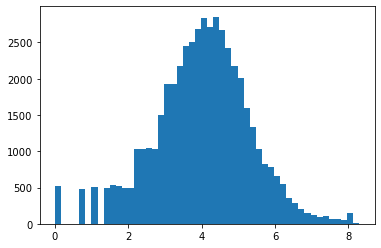

In [12]:
y_log = np.log(y)

plt.hist(y_log, bins = 50)
plt.show()

In [16]:
y_train_log = np.log(y_train)

lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)
lgbm.fit(X_train, y_train_log)

print('LGBM scores: ')

print('Train error: ')
y_log_pred_train = lgbm.predict(X_train)
y_preds_train = np.exp(y_log_pred_train)

mae = mean_absolute_error(y_train, y_preds_train)
print("Mean absolute error: %0.3f" % mae)

print('Test error: ')

y_log_pred_valid = lgbm.predict(X_valid)
y_preds_valid = np.exp(y_log_pred_valid)

mae = mean_absolute_error(y_valid, y_preds_valid)
print("Mean absolute error: %0.3f" % mae)


LGBM scores: 
Train error: 
Mean absolute error: 47.603
Test error: 
Mean absolute error: 51.274
